In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import numpy as np
import pandas as pd

In [2]:
train_folder = 'data/train_/'
test_folder = 'data/test_/'
data_folder = 'data/'
random_subset = 10

In [3]:
files = !ls {train_folder}
files = np.array(files)
n = len(files)

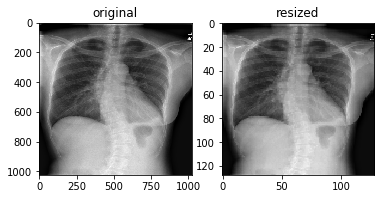

In [4]:
img = cv2.imread(f'{train_folder}{files[10]}',1)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
img2 = cv2.resize(img,(128,128))
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('resized')

In [5]:
idx = np.random.choice(n,size=(random_subset,),replace=False)
for i, _ in enumerate(files[idx]):
    img = cv2.imread(f'{train_folder}{files[i]}',1)
    # all channels are same
    assert (np.logical_and( (img[:,:,0]==img[:,:,1]).all(), (img[:,:,1]==img[:,:,2]).all()) == True )

In [6]:
labels_tr = pd.read_csv(f'{data_folder}train.csv')
labels_tr.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [7]:
labels_tr.isnull().values.any() #no null values

False

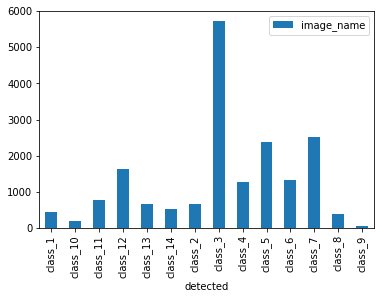

In [8]:
classes = pd.Series(['class_1','class_2', 'class_3', 'class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13','class_14',])
labels_tr.groupby('detected').count().reset_index().plot(kind='bar', x='detected',y='image_name')

In [9]:
rdc = labels_tr.groupby(['gender','detected']).count()


In [10]:
F = rdc.loc['F']
M = rdc.loc['M']
M

,row_id,age,view_position,image_name
detected,,,,
class_1,240,240,240,240
class_10,119,119,119,119
class_11,464,464,464,464
class_12,921,921,921,921
class_13,388,388,388,388
class_14,335,335,335,335
class_2,306,306,306,306
class_3,3230,3230,3230,3230
class_4,776,776,776,776


In [11]:
(M.index == F.index).any()

True

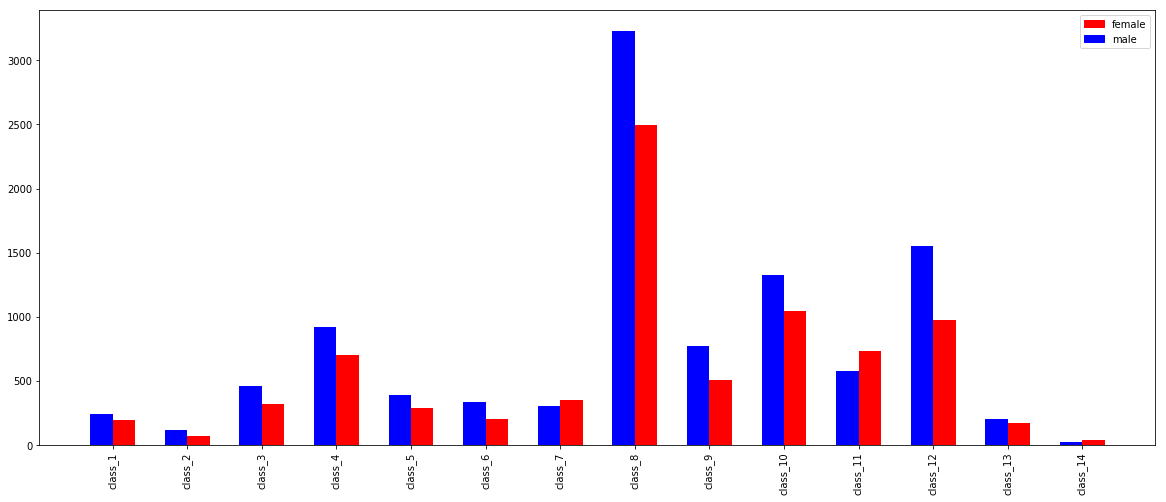

In [12]:
plt.figure(figsize = (20,8))
red_patch = mpatches.Patch(color='red', label='female')
blue_patch = mpatches.Patch(color='blue', label='male')
ax = plt.subplot(111)
plt.xticks(np.arange(len(classes)), classes, rotation=90)
ax.bar(np.arange(len(classes)) - 0.3, M['age'],width=0.3,color='b',align='edge')
ax.bar(np.arange(len(classes)), F['age'],width=0.3,color='r',align='edge')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

In [13]:
files = labels_tr['image_name']
files[:10]

0        scan_0000.png
1        scan_0001.png
2       scan_00010.png
3     scan_0001000.png
4    scan_00010000.png
5    scan_00010001.png
6    scan_00010003.png
7    scan_00010004.png
8    scan_00010006.png
9    scan_00010007.png
Name: image_name, dtype: object

In [14]:
labels_tr.set_index('image_name').head()

,row_id,age,gender,view_position,detected
image_name,,,,,
scan_0000.png,id_0,45,M,0,class_3
scan_0001.png,id_1,57,F,0,class_3
scan_00010.png,id_10,58,M,0,class_3
scan_0001000.png,id_1000,64,M,0,class_6
scan_00010000.png,id_10000,33,M,1,class_3


In [15]:
def show_sample(img,label = None,mapping=None):
    plt.imshow(img)
    if label:
        plt.title("label={} and class_name={}".format(label,mapping[label]))

In [16]:
t = labels_tr
t.head()
# t['codes'] = t.detected.astype('category')
# for i in 
# t['codes'] = t.detected
dict(enumerate(t.detected.astype('category').cat.categories))


{0: 'class_1',
 1: 'class_10',
 2: 'class_11',
 3: 'class_12',
 4: 'class_13',
 5: 'class_14',
 6: 'class_2',
 7: 'class_3',
 8: 'class_4',
 9: 'class_5',
 10: 'class_6',
 11: 'class_7',
 12: 'class_8',
 13: 'class_9'}

## Data Loading and Transformations

In [17]:
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
import os
import PIL.Image as Image

In [18]:
class XRayDataset(Dataset):
    
    def __init__(self, csv_file, path, transform = None):
        self.df = pd.read_csv(csv_file)
        self.df['detected_id'] = self.df.detected.astype('category').cat.codes
        self.path = path
        self.idx_to_classes = dict(enumerate(self.df.detected.astype('category').cat.categories))
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.path,'train_',self.df.loc[idx,'image_name'])
        img = cv2.imread(img_path,1)
        label = self.df.loc[idx,'detected_id']
        sample = {'image':img,
                  'label':label
                 }
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample      


0 (1024, 1024, 3) 7
1 (1024, 1024, 3) 7
2 (1024, 1024, 3) 7
3 (1024, 1024, 3) 10


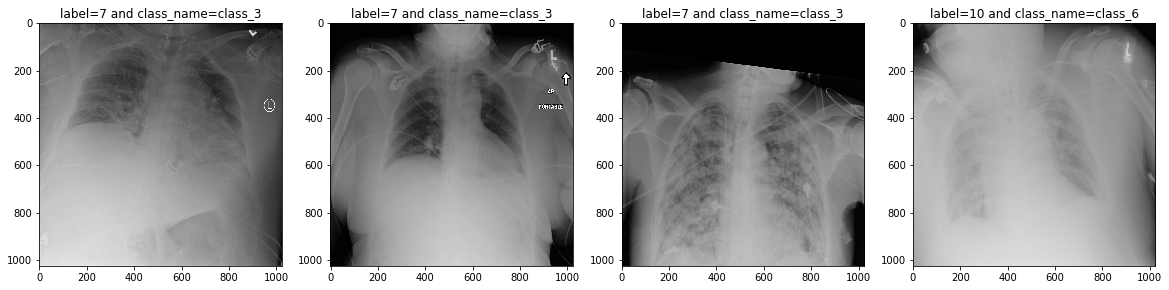

In [19]:
train_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',None)

fig = plt.figure(figsize=(20,5))


for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
    show_sample(sample['image'],sample['label'],train_dataset.idx_to_classes)

    if i == 3:
        plt.show()
        break


In [20]:
tfms = {    
    'train_aug': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((250,250)),
        transforms.RandomCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    
    'test_aug': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227,227)),
#         transforms.CenterCrop(227),
        transforms.ToTensor()
    ]),
    
    'no_aug' : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227,227)),
        transforms.ToTensor()
    ])
}

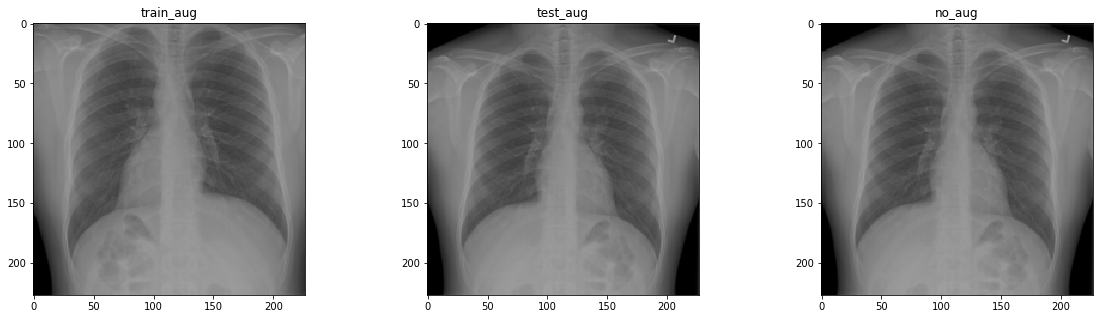

In [21]:
fig = plt.figure(figsize=(20,5))

sample = train_dataset[100]

for i,k in enumerate(tfms):
#     print(sample['image'].shape)
    tfmed = tfms[k](sample['image'])
#     print(tfmed.shape)
    
    ax = plt.subplot(1,3,i+1)
    ax.set_title(k)
    show_sample(tfmed.permute(1,2,0))   
    
    

In [22]:
transformed_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',transform=tfms['train_aug'])

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i,sample['image'].size(),sample['label'])

    if i == 3:
        break

0 torch.Size([3, 227, 227]) 7
1 torch.Size([3, 227, 227]) 7
2 torch.Size([3, 227, 227]) 7
3 torch.Size([3, 227, 227]) 10


In [39]:
dataloader = DataLoader(transformed_dataset,
                        batch_size=32,
                        shuffle=True,
                        num_workers=4
                       )

In [40]:
print(len(dataloader))
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['label'].size())
    if i_batch==3:
        break

581
0 torch.Size([32, 3, 227, 227]) torch.Size([32])
1 torch.Size([32, 3, 227, 227]) torch.Size([32])
2 torch.Size([32, 3, 227, 227]) torch.Size([32])
3 torch.Size([32, 3, 227, 227]) torch.Size([32])
